In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import hyp2f1
from scipy.stats import norm

In [2]:
n = 200

repeat = 10000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1, axis=1)
w2 = np.cumsum(Zn2, axis=1)

In [3]:
# Gaussian distributions, as reference
N_prime = norm.pdf
N = norm.cdf


def black_scholes_call(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call


def vega_func(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    """

    # calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / sigma * np.sqrt(T)

    # see hull derivatives chapter on greeks for reference
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega


def implied_volatility_call_newton(C, S, K, T, r, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3
    eps = np.finfo(float).eps
    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use newton rapshon to update the estimate
        sigma = sigma - diff / (eps+vega_func(S, K, T, r, sigma))

    return sigma


def implied_volatility_call_bisection(C, S, K, T, r, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    a = 0
    b = 1
    sigma = 0.5

    for i in range(max_iterations):

        # calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        # use bisection method to update the estimate
        if diff < 0:
            if black_scholes_call(S, K, T, r, b) < C:
                a = b
                b = 2 * b
            a = sigma
            sigma = 0.5 * (a + b)
        if diff > 0:
            b = sigma
            sigma = 0.5 * (a + b)

    return sigma


def hallerbach_approximation(C, S, K, T, r):

    X = K * np.exp(-r * T)
    sigma = (1 / np.sqrt(T) * np.sqrt(2 * np.pi) / (2 * (S + X))) * (
        2 * C
        + X
        - S
        + np.sqrt(
            (2 * C + X - S) ** 2
            - 1.85 * (S + X) * (X - S) ** 2 / (np.pi * np.sqrt(X * S))
        )
    )
    # print((2 * C + X - S) ** 2 - 2 * (S + X) * (X - S) ** 2 / (S * np.pi))

    return sigma


In [4]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        eta**2
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [5]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return c**2 * (aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a))

def covariance_frac(T, H, c):
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [6]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1, T=1.5):

    cov = covariance_exp(eta=eta, lam=lam, T=T)
    L = np.linalg.cholesky(cov)
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1, T=1.5):
    times = np.linspace(0, T, n + 1)
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1, T=1.5):

    cov = covariance_frac(T=T, H=H, c=c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

In [7]:

def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", save_pic=False):
    T=1.5
    times = np.linspace(0, T, n + 1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

In [8]:
def sample_B(rho=0.5, T=1.5):
    sample = rho*np.sqrt(T/n)*w1+np.sqrt(1-rho**2)*np.sqrt(T/n)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

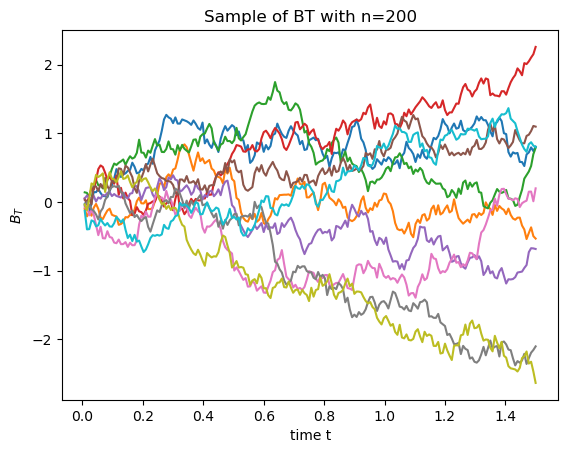

In [9]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

In [10]:
def Sigma(X, vars, ksi=0.5, a0=1, a1=1):
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

In [11]:
def sample_S_exp(rho=0.5, eta=1, lam=1, S0=[100], ksi=0.5, a0=1, T=[1.5], pre=False):
    assert(len(S0)==len(T))   
    sample=[]

    for T_unique in np.unique(T):

        X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T_unique)
        vars = np.diagonal(cov)

        sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        
        for i in range(len(S0)):

            if(T[i]==T_unique):
                sample.append(S0[i]*sample_S)
        
        if pre:    
            mean = np.mean(sample[0][:, -1])
            var = np.var(sample[0][:, -1])
            demi_width_IC = np.sqrt(var/repeat) * 1.96
            print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
            print("IC(95%%) = [%1.3f, %1.3f] \n" \
            %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)

def sample_S_frac(rho=0.5, H=0.5, c=1, S0=[100], ksi=[0.5], a0=1, T=1.5, pre=False):
    assert(len(S0)==len(T))
    sample=[]
    for T_unique in np.unique(T):
        X_sample, cov = sample_XT_frac(H=H, c=c, T=T_unique)
        vars = np.diagonal(cov)

        sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))

        B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T_unique)))
        sum1 = np.cumsum((0.5*(sigma[:, :-1]+sigma[:, 1:]))**2*T_unique/n, axis=1)
        sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
        sample_S = np.hstack((np.ones(repeat).reshape(-1,1), np.exp(-0.5*sum1+sum2)))
        
        for i in range(len(S0)):
            if(T[i]==T_unique):
                sample.append(S0[i]*sample_S)
        
        if pre:    
            mean = np.mean(sample[0][:, -1])
            var = np.var(sample[0][:, -1])
            demi_width_IC = np.sqrt(var/repeat) * 1.96
            print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
            print("IC(95%%) = [%1.3f, %1.3f] \n" \
            %(mean-demi_width_IC, mean + demi_width_IC))
            
    return np.array(sample)

S_T: mean=99.514 var=1842.387
IC(95%) = [98.672, 100.355] 

(1, 10000, 201)


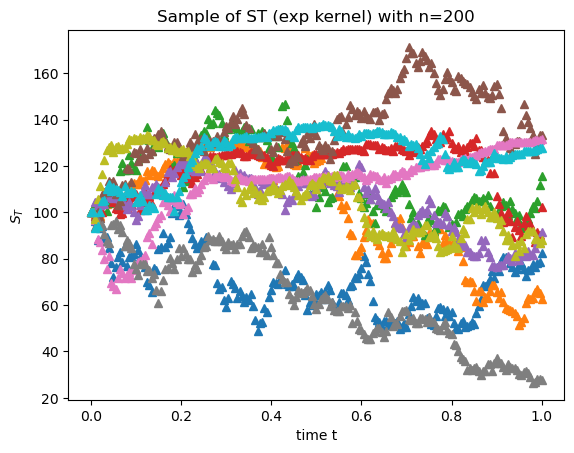

In [12]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=[T], pre=True)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[0][:10].T, "^")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) with n={n}")
plt.show()


S_T: mean=99.671 var=1727.080
IC(95%) = [98.856, 100.485] 

(1, 10000, 201)


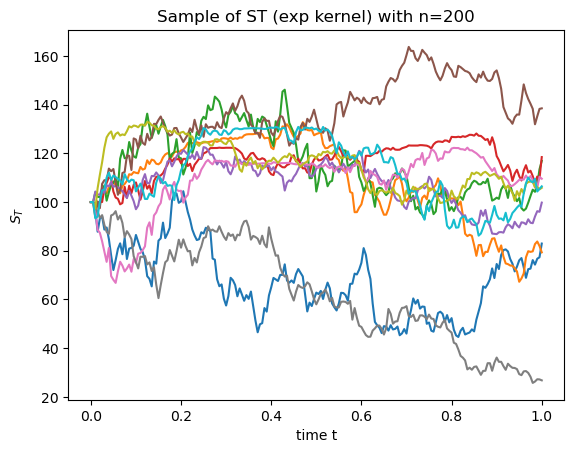

In [13]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_frac(rho=-0.8, T=[T], pre=True)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[0][:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) with n={n}")
plt.show()


In [14]:
%%time
# Here we calibrate using scipy.optimize for plural slices
from scipy.optimize import least_squares


def loss_1(x, K, y, S0s, Ts, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(S0=S0s, T=Ts, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(S0=S0s, T=Ts, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    return np.array([np.mean(np.maximum(ST[i]-K[i], 0))-y[i] for i in range(len(y))])

def loss_2(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(S0=S0, T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(S0=S0, T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    return np.array([implied_volatility_call_newton(C=np.mean(np.maximum(ST[i]-K[i], 0)),
                                                    S=S0[i],
                                                    K=K[i],
                                                    T=T,
                                                    r=0
                                                    ) 
                     - implied_volatility_call_newton(C=y[i],
                                                    S=S0[i],
                                                    K=K[i],
                                                    T=T,
                                                    r=0
                                                    )
                     for i in range(len(y))])

def loss_3(x, K, y, S0, T, kernel: str):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
        kernel: type of kernel-'frac' or 'exp'
    '''
    if kernel=='frac':
        ST = sample_S_frac(S0=S0, T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    if kernel=='exp':
        ST = sample_S_exp(S0=S0, T=T, rho=x[0], lam=x[1], eta=x[2], ksi=x[3], a0=x[4])[:,:,-1]
    
    return np.array([(np.mean(np.maximum(ST[i]-K[i], 0))-y[i])/np.sqrt(vega[i]) for i in range(len(y))])

def calibration(Ks, y, S0s, Ts, kernel="frac", loss=loss_1):
    if kernel == "frac":
        x0 = np.array([-0.7, 0.25, 0.5, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0], [-0.5, 0.5, 2, 2, 2])
    else:
        x0=np.array([-0.7, 1, 1, 0.2, 0.5])
        bounds=([-1, 0, 0, 0, 0], [-0.5, 2, 3, 3, 3])
    return least_squares(loss, x0, bounds=bounds, args=(Ks, y, S0s, Ts, kernel), ftol=1e-9, xtol=1e-9, gtol=1e-9, verbose=1)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.2 µs


In [15]:
def test_implied_vol(S0, T, Ks, call_models, vol_markets, loss_type="1", model="frac"):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vol_models = np.array([implied_volatility_call_bisection(C=call_models[i], S=S0[i], K=Ks[i], T=T[i], r=0, tol=1e-7, max_iterations=1000) for i in range(len(Ks))])
    # vol_markets = np.array([implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))])
    
    ax.plot(Ks/S0, vol_models, label="model")
    ax.scatter(Ks/S0, vol_markets, label="market", s=0.4, c="red")

    ax.set_xlabel('K/S')
    ax.set_ylabel('$Implied volatility$')
    ax.set_title(f"loss type: loss{loss_type}, model: {model}")

    plt.legend(loc='best')

    plt.show()
    
    loss_MSE = np.mean((vol_markets-vol_models)**2)
    print("Mean squared error:{:.3g}".format(loss_MSE))
  

In [16]:
# Ks=np.arange(80,122,2)
# y = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))])

# res = calibration(Ks, y, S0=100, T=1.5, loss=loss_1)
# print(res)

# params = res.x

# call_markets = np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(Ks))]) 
# call_models= np.array([call_frac(S0=100, K=Ks[i], T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]) for i in range(len(Ks))])  
# test_implied_vol(S0=100, T=1.5, Ks=Ks, call_models=call_models, call_markets=call_markets) 

In [42]:

# Read data
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

# Remove all data not traded in reality
data = data[data["trade_volume"]>0]

# Rename some columns according to convention
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

# We only process data for calls here
data = data[data['option_type']=='C']
data = data[data["root"]=="SPX"]
# Calculate the time difference based on the quote date and expiration and convert to days
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days))

# We use the average of bid and ask for the actual market price
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])

print("All maturities: \n", np.unique(np.sort(data["T"].to_numpy())))

T = 49
print("Chosen maturity:", T)
data = data[data['T']==T]
S0 = data['S0'].to_numpy()[0]
data = data[data['S0']==S0]
# data = data[np.abs((data["K"]-S0)/S0)<0.2]

Ks = data['K'].to_numpy()
call_markets = data['call_markets'].to_numpy()
vega = data["vega"].to_numpy()
vol_markets = data["implied_volatility"].to_numpy()
print("Number of points:", len(Ks) )


All maturities: 
 [  14   49   77  105  140  168  196  231  259  287  322  350  378  469
  658  840 1568 1932]
Chosen maturity: 49
Number of points: 172


`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 4.0829e+08, final cost 1.6602e+01, first-order optimality 4.04e-02.


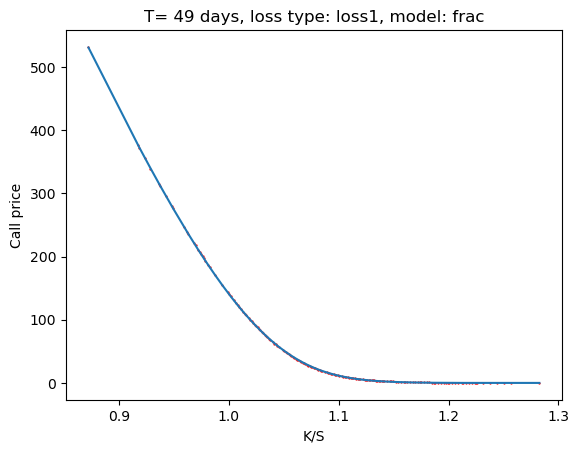

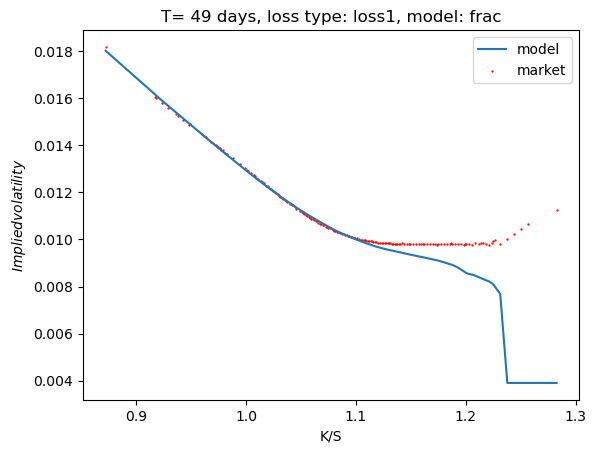

Mean squared error:1.57e-06


In [43]:
vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0, Ks[i], T, r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])

res = calibration(Ks=Ks, y=call_markets, S0=S0, T=T, loss=loss_1)
params = res.x

ST = sample_S_frac(S0=S0, T=T, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T} days, loss type: loss1, model: frac")
plt.show()


test_implied_vol(S0=S0, T=T, Ks=Ks, call_models=call_models, vol_markets=vol_markets)    

`ftol` termination condition is satisfied.
Function evaluations 47, initial cost 3.7888e+16, final cost 1.4579e+09, first-order optimality 6.23e+07.


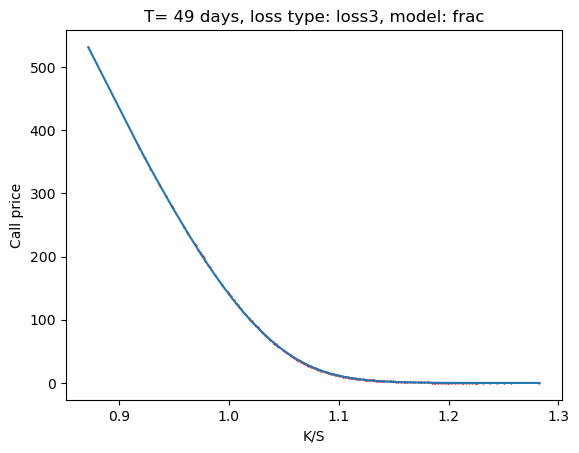

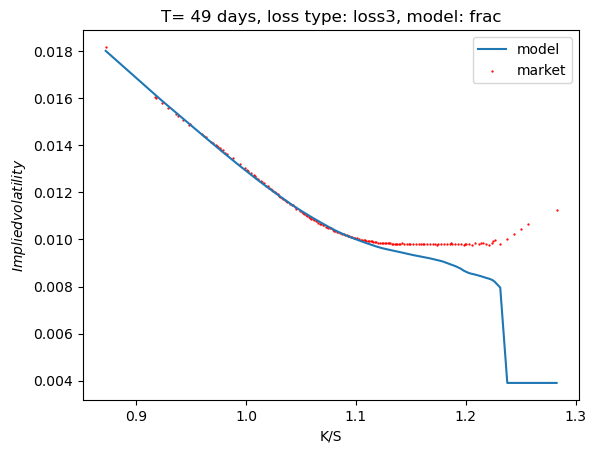

Mean squared error:1.54e-06


In [44]:
vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0, Ks[i], T, r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])

res = calibration(Ks=Ks, y=call_markets, S0=S0, T=T, loss=loss_3)
params = res.x

ST = sample_S_frac(S0=S0, T=T, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4])[:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T} days, loss type: loss3, model: frac")
plt.show()

test_implied_vol(S0=S0, T=T, Ks=Ks, call_models=call_models, vol_markets=vol_markets, loss_type="3")    

`ftol` termination condition is satisfied.
Function evaluations 39, initial cost 3.2041e+08, final cost 8.9018e+00, first-order optimality 2.12e-02.


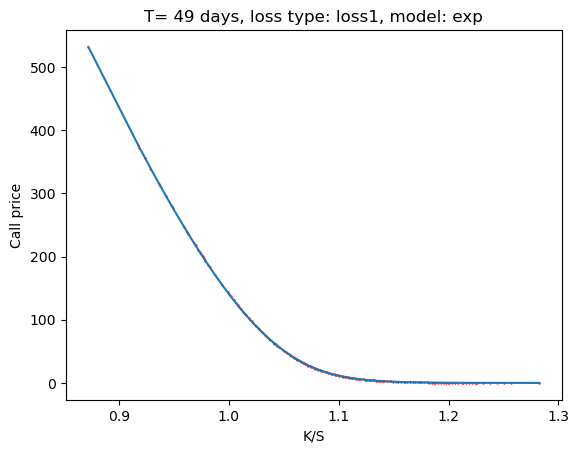

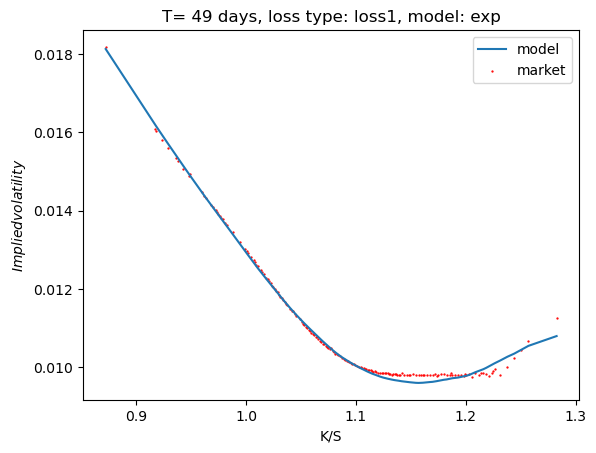

Mean squared error:1.08e-08


In [45]:
vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0, Ks[i], T, r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])

x0=[]
res = calibration(Ks=Ks, y=call_markets, S0=S0, T=T, kernel="exp", loss=loss_1)
params = res.x

ST = sample_S_exp(S0=S0, T=T, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T} days, loss type: loss1, model: exp")
plt.show()


test_implied_vol(S0=S0, T=T, Ks=Ks, call_models=call_models, vol_markets=vol_markets, model="exp")    

`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 2.9760e+16, final cost 3.9364e+08, first-order optimality 3.68e+05.


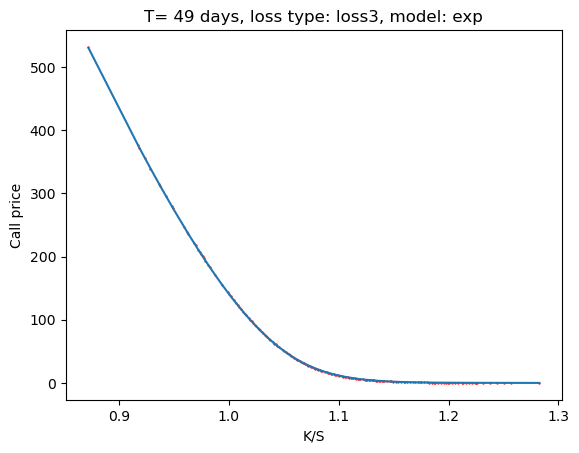

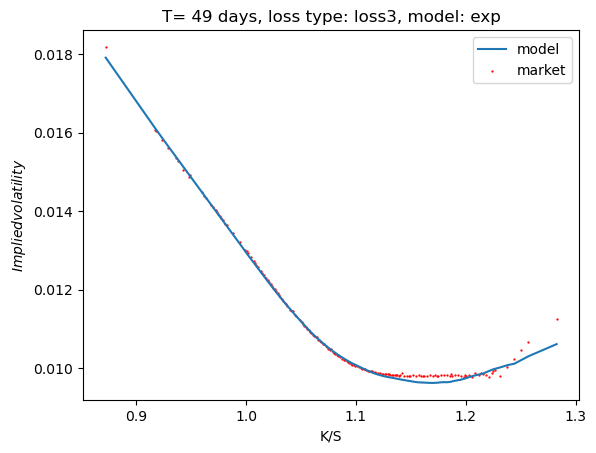

Mean squared error:9.76e-09


In [46]:
vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0, K=Ks[i], T=T, r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0, Ks[i], T, r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])

x0=[]
res = calibration(Ks=Ks, y=call_markets, S0=S0, T=T, kernel="exp", loss=loss_3)
params = res.x

ST = sample_S_exp(S0=S0, T=T, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[:,-1]

call_models = [np.mean(np.maximum(ST-Ks[i], 0))  for i in range(len(Ks))]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Ks/S0, call_markets, s=0.4, c="red")
ax.plot(Ks/S0, call_models, "-")

ax.set_xlabel("K/S")
ax.set_ylabel("Call price")
ax.set_title(f"T= {T} days, loss type: loss3, model: exp")
plt.show()


test_implied_vol(S0=S0, T=T, Ks=Ks, call_models=call_models, vol_markets=vol_markets, loss_type="3", model="exp")    

In [17]:
# Read data
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')

# Remove all data not traded in reality
data = data[data["trade_volume"]>0]

# Rename some columns according to convention
data.rename(columns={'strike': 'K','implied_underlying_price_1545':'S0', "implied_volatility_1545":"implied_volatility", "vega_1545":"vega"}, inplace=True)

# We only process data for calls here
data = data[data['option_type']=='C']
data = data[data["root"]=="SPX"]
# Calculate the time difference based on the quote date and expiration and convert to days
data['T'] = (data["expiration"].map(lambda x: pd.Timestamp(x)) - data["quote_date"].map(lambda x: pd.Timestamp(x))).map(lambda x: int(x.days))

# We use the average of bid and ask for the actual market price
data['call_markets'] = 0.5 * (data['bid_1545']+data['ask_1545'])



data = data[(data['T']>=7) & (data["T"]<=366)]

S0s = data['S0'].to_numpy()
Ks = data['K'].to_numpy()
Ts = data['T'].to_numpy()

call_markets = data['call_markets'].to_numpy()
vega = data["vega"].to_numpy()
vol_markets = data["implied_volatility"].to_numpy()

assert len(S0s)==len(Ks)

print("All maturities: \n", np.unique(Ts))
print("Number of points:", len(Ks))

All maturities: 
 [ 14  49  77 105 140 168 196 231 259 287 322 350]
Number of points: 678


In [19]:
vol_markets = [implied_volatility_call_bisection(C=call_markets[i], S=S0s[i], K=Ks[i], T=Ts[i], r=0) for i in range(len(Ks))]
vega = np.array([vega_func(S0s[i], Ks[i], Ts[i], r=0, sigma = vol_markets[i]) + 1e-8 for i in range(len(Ks))])

res = calibration(Ks=Ks, y=call_markets, S0s=S0s, Ts=Ts, kernel="exp", loss=loss_1)
# params = res.x

# ST = sample_S_exp(S0=S0s, T=Ts, rho=params[0], lam=params[1], eta=params[2], ksi=params[3], a0=params[4])[:,:,-1]

# call_models = [np.mean(np.maximum(ST[i]-Ks[i], 0))  for i in range(len(Ks))]
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(Ks/S0s, call_markets, s=0.4, c="red")
# ax.plot(Ks/S0s, call_models, "-")

# ax.set_xlabel("K/S")
# ax.set_ylabel("Call price")
# ax.set_title(f"loss type: loss1, model: exp")
# plt.show()


# test_implied_vol(S0=S0s, T=Ts, Ks=Ks, call_models=call_models, vol_markets=vol_markets, model="exp")    

: 

: 